In [1]:
% matplotlib inline

import numpy as np, nibabel as nib
import utils.plotting_lighterbg as plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import pandas as pd
import statsmodels.formula.api as smf

sns.set_style('white')
sns.set_context('talk')

## Functional connectivity distance

In [2]:
ddir = '/Users/sabine/data/macaque/resting'

In [3]:
cort = np.where(nib.load('%s/MacaqueYerkes19.L.atlasroi.10k_fs_LR.shape.gii' % ddir).darrays[0].data==1)[0]
coords = nib.load('%s/%s.L.inflated.10k_fs_LR.surf.gii' % (ddir, 'Willow')).darrays[0].data
faces = nib.load('%s/%s.L.inflated.10k_fs_LR.surf.gii' % (ddir, 'Willow')).darrays[1].data
sulc = nib.load('%s/%s.L.sulc.10k_fs_LR.shape.gii' % (ddir, 'Willow')).darrays[0].data

In [4]:
mdist = nib.load('%s/cifti.MEAN_meandist.10k_fs_LR.dscalar.nii' % ddir).get_data().squeeze()[:10242] # left hemi
mdist.shape

(10242,)

/Users/sabine/anaconda2/envs/distconnect/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


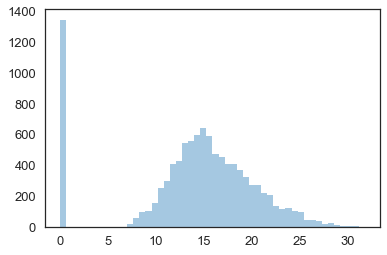

In [5]:
_ = sns.distplot(mdist, kde=False)

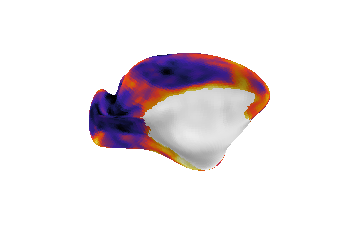

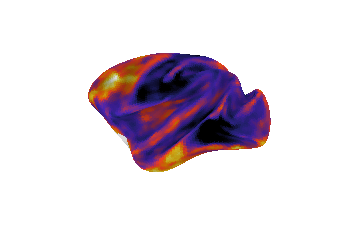

In [6]:
for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  mdist, mask=cort,
                                  bg_map=sulc,
                                  bg_on_stat=True,
                                  alpha=1,
                                  vmin=10,
                                  vmax=30,
                                  azim=azim,
                                  cmap='CMRmap')
    
    
    #plt.savefig('/nobackup/hunte1/sabine/tractdist/figures_ms/images/condist_%s' % (azim), dpi=300)

## Distance from primary cortex

In [7]:
import gdist
from surfdist.utils import surf_keep_cortex, translate_src, recort

vertices, triangles = surf_keep_cortex((coords, faces), cort)

def dist_calc_fast(src, cortex, vertices, triangles, surf):
    src_new = translate_src(src, cortex)
    data = gdist.compute_gdist(vertices, triangles, source_indices=src_new)
    dist = recort(data, surf, cortex)
    del data
    return dist

In [8]:
# surf midthickness for dist calc

f_surf_mid = '%s/MacaqueYerkes19.L.midthickness.10k_fs_LR.surf.gii' % ddir
coords_mid = nib.load(f_surf_mid).darrays[0].data
faces_mid = nib.load(f_surf_mid).darrays[1].data
surf_mid = tuple((coords_mid, faces_mid))

In [9]:
atlas = nib.load('%s/L.MarkovCC12_M132_91-area.10k_fs_LR.label.gii' % ddir)#.darrays[0].data

In [10]:
#atlas.labeltable.get_labels_as_dict()
prim_names = ['V1', 'CORE', 'F1', '3'] #, 'Gu', 'PIRIFORM']
prim_keys = [83, 36, 39, 3] #, 47, 64]

In [11]:
prim_dist = np.empty((len(prim_keys), 
                      coords.shape[0]))

for n, key in enumerate(prim_keys):
    prim_dist[n] = dist_calc_fast(np.where(atlas.darrays[0].data==key)[0], 
                                  cort, vertices, triangles, surf_mid)
    
prim_dist = np.min(prim_dist, axis=0)

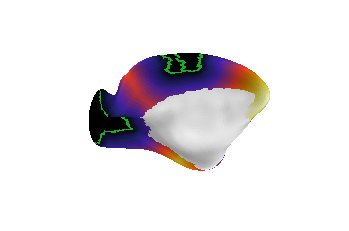

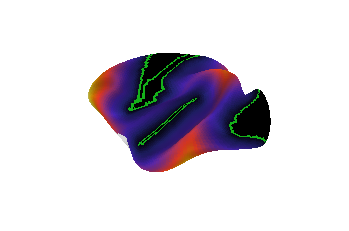

In [12]:
labels_prim = [np.where(atlas.darrays[0].data==key)[0] for key in prim_keys]

for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  prim_dist, mask=cort,
                                  labels = labels_prim, 
                                  azim=azim,
                                  bg_map=sulc, bg_on_stat=True, 
                                  cmap='CMRmap')
    
    #plt.savefig('/nobackup/hunte1/sabine/tractdist/figures_ms/images/primdist_%s' % (azim), dpi=300)

In [13]:
print prim_dist.min(), prim_dist.max()

0.0 30.734746335528918


## Average values per area

In [14]:
annot = np.array([atlas.labeltable.get_labels_as_dict()[key] for key in atlas.darrays[0].data])

df = pd.DataFrame({'area': annot, 
                   'meandist': mdist, 
                   'primdist': prim_dist})

df['area'] = df['area'].astype(str).values

print df.shape
df.head()

(10242, 3)


,area,meandist,primdist
0,23,19.625196,7.271953
1,V6A,11.038814,7.265151
2,2,14.217127,2.262008
3,F1,16.657005,0.000000
4,V1,19.430664,0.000000


In [15]:
df = df.groupby('area').mean().reset_index()

order = df.sort_values('primdist').index
order = [str(area) for area in order]

df.sort_values('primdist', ascending=False).head(15)

,area,meandist,primdist
16,32,22.155176,28.267347
1,10,20.929880,27.641260
5,14,19.249905,26.849069
12,25,21.125153,26.684684
10,24c,17.900663,25.207043
2,11,20.747677,24.529078
56,OPAI,17.327223,24.403512
31,9,20.208588,23.180494
4,13,17.193634,22.088094
21,46v,21.082594,21.629844


## Exclusion of anteriormost PFC 
### Regions that lie further from primary cortex than anyother region in the cortex

In [16]:
excl_areas = list(df[df.primdist>20].area)
excl_areas

['10', '11', '13', '14', '24c', '25', '32', '46d', '46v', '9', 'F6', 'OPAI']

In [17]:
df['inclusion'] = ((~df.area.isin(excl_areas)) & (df.area != '???'))

In [18]:
# for finding keys: atlas.labeltable.get_labels_as_dict()
excl_keys = [6, 7, 9, 10, 18, 12, 14, 23, 24, 5, 44, 56]

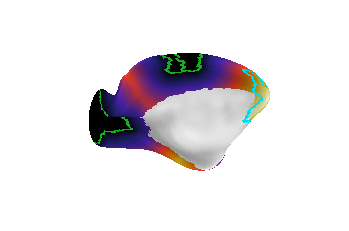

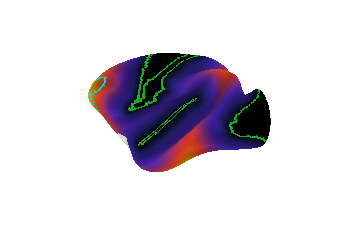

In [19]:
labels_excl_area = [np.where(atlas.darrays[0].data==key)[0] for key in excl_keys]

label_excl_areas = list()

for l in labels_excl_area:
    label_excl_areas += list(l)
    
label_excl_areas = np.array(label_excl_areas)


labels_prim = [np.where(atlas.darrays[0].data==key)[0] for key in prim_keys]

#labels = labels_prim + label_excl_area
labels_prim.append(label_excl_areas)

for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  prim_dist, mask=cort,
                                  labels = labels_prim,#label_excl_area,
                                  label_cpal = ["green", "green", "green", "green", "aqua blue"],
                                  azim=azim,
                                  sulc=sulc, bg_map=sulc, 
                                  bg_on_stat=True, cmap='CMRmap')
    
    #plt.savefig('/Users/sabine/Downloads/gdist_from_prim_%s' % (azim), dpi=300)

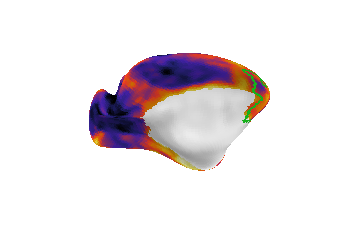

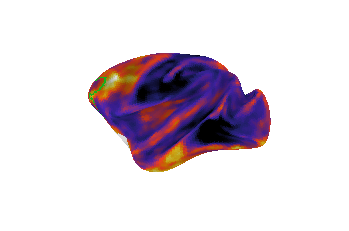

In [20]:
labels_excl_area = [np.where(atlas.darrays[0].data==key)[0] for key in excl_keys]

label_excl_areas = list()

for l in labels_excl_area:
    label_excl_areas += list(l)
    
label_excl_areas = [np.array(label_excl_areas),]


for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  mdist, mask=cort,
                                  labels = label_excl_areas, 
                                  azim=azim,
                                  vmin=10,
                                  vmax=30,
                                  sulc=sulc,
                                  bg_map=sulc, bg_on_stat=True, cmap='CMRmap')

# STATS
## Relationship of connectivity distance with distance from primary cortex

In [21]:
model = smf.ols(formula='meandist ~ primdist', data=df[df.inclusion==True]).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:               meandist   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     31.17
Date:                Fri, 05 Oct 2018   Prob (F-statistic):           3.40e-07
Time:                        01:10:27   Log-Likelihood:                -203.04
No. Observations:                  79   AIC:                             410.1
Df Residuals:                      77   BIC:                             414.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6350      0.733     18.613      0.0

In [22]:
model.pvalues

Intercept    3.150420e-30
primdist     3.401557e-07
dtype: float64

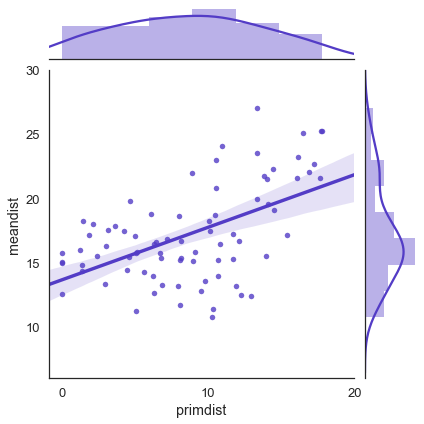

In [23]:
g = sns.jointplot(x="primdist", 
                  y="meandist", 
                  data=df[df.inclusion==True], 
                  kind='reg', 
                  color="#533cc6", 
                  xlim=(-.9,20), 
                  ylim=(6,30),
                  stat_func=None,
                  scatter_kws={"s": 30})


_ = plt.xticks([0,10,20])
_ = plt.yticks([10,15, 20,25,30])

#g.savefig('/Users/sabine/Downloads/relationship_func.png', dpi=300)

### Any serious outliers?

In [24]:
df.loc[df.inclusion==True ,'func_resid'] = model.resid
df.loc[df.inclusion==True ,'func_stud_resid'] = model.outlier_test()['student_resid']
df.loc[df.inclusion==True ,'func_unadj_p'] = model.outlier_test()['unadj_p']
df.loc[df.inclusion==True ,'func_bonf_p'] = model.outlier_test()['bonf(p)']

In [25]:
df[df.inclusion==True].sort_values('func_stud_resid').head()

,area,meandist,primdist,inclusion,func_resid,func_stud_resid,func_unadj_p,func_bonf_p
91,VIP,10.753365,10.277500,True,-7.094935,-2.291565,0.024702,1.0
51,LIP,12.343019,12.931032,True,-6.593097,-2.128836,0.036508,1.0
62,PIP,11.330593,10.320438,True,-6.535310,-2.099931,0.039053,1.0
74,TEOm,12.470252,12.225335,True,-6.176564,-1.984027,0.050864,1.0
53,MIP,13.166954,11.923208,True,-5.356004,-1.708529,0.091620,1.0


In [26]:
df[df.inclusion==True].sort_values('func_stud_resid').tail()

,area,meandist,primdist,inclusion,func_resid,func_stud_resid,func_unadj_p,func_bonf_p
29,8m,21.975098,8.927106,True,4.680392,1.482034,0.142466,1.000000
71,SUBICULUM,25.069300,16.464733,True,4.684542,1.508572,0.135554,1.000000
28,8l,22.957924,10.557328,True,4.994908,1.586311,0.116821,1.000000
13,29/30,24.083555,10.957103,True,5.956652,1.905991,0.060433,1.000000
30,8r,27.054497,13.320698,True,7.958637,2.608154,0.010955,0.865422


In [27]:
df.to_pickle('./data/df_func.pkl') # for combining with struct later